<h1><center>Yelp - Recommendation System</center></h1>
<div style="text-align: right"> Qi Wang</div>
<div style="text-align: right"> Guoqiang Chen</div>
<div style="text-align: right"> Fay Wu</div>


The folder that contains all the files needed for the notebook can be downloaded through:
https://ucsb.box.com/s/t5e83x2ob8yseqasm1737h2oafhao1uu

<a id = 'catelog'></a>
## Contents
1. [Introduction](#intro)
2. [Data Description](#data)
3. [Neighborhood-Based Recommendation System](#neighbor)

    3.1 [Rating, Prediction and Recommendation](#rating)    
    -  [How to measure the similarity?](#3.1.1)
    -  [How many neighbors to keep?](#3.1.2)
    -  [How to generate items from the neighbors?](#3.1.3)
    -  [Model Building and Evaluation](#3.1.4)
    -  [Model Selection by Parameter Tuning](#3.1.5)
    -  [Discussion about Rating-based recommendation system](#3.1.6)
    
   3.2 [Topic modeling of Review Data](#3.2)
   -  [Review data pre-possessing](#3.2.1)
   -  [NMF- Topic Modeling](#3.2.2)
   -  [LDA- Topic Modeling and Comparison with NMF](#3.2.3)
   -  [Clustering Based on NMF](#3.2.4)
    
   3.3 [K-modes Clustering](#3.3)
   -  [First Feature Selection](#3.3.1)
   -  [Missing Values and  Second Round of Variables Selection](#3.3.2)
   -  [Clustering Method: K-modes Cluster](#3.3.3)
   -  [Discussion about the K-modes method and other methods](#3.3.4)
4. [Summary and Discussion](#4)

<a id = 'intro'></a>
# 1. Introduction

“What to eat?” is a question originated from ancient time. A nowadays version is “which restaurant for dinner?” Facing with tons of choices, personally try all of them is impossible. Take California for example, official data show that in total there are 72,387 restaurants. If one man chooses to attend a new restaurant every day, it will take him almost 200 years to experience all these places. So is there a smarter way? We can directly ask foodies around us for recommendations. They are like nodes in a restaurant-network, helping us extend our boundaries. Furthermore, among those foodie friends, we’d better inquire those who have similar taste with us, since they have greater probability to give us suitable suggestions. 

Inspiring by this intuitive idea, we developed a recommendation system based on user similarity in taste space. Yelp aggregates rating and review data from its users. We took advantage of these data to suggest appetizing restaurants. For each specific target user, we search the whole database, and figure out the most similar neighbors, dependent on ratings and reviews. Two different methods are utilized for finding neighbors, based on ratings and non-ratings, separately. For rating data, we calculate the _pearson correlation coefficient_ (PCC) on co-rating restaurants between every other user with our target user to generate a similarity ranking. For non-rating data such as reviews and restaurant features, we clustered users into different groups, and the same group members are treated as neighbors. We utilized data from top neighbors to give out recommendations. 

Based on this similarity-system, we further added the prediction module, with which we can predict rating values for those novel restaurants that target users have never been to. We also discuss the drawback of our method and work that can be performed in the future.




[Return to the Top](#intro)

<a id = 'data'></a>
# 2. Data Description

The Yelp Open Dataset offers rich and various resource given by 520 million user reviews come from 1,300,000 users for 174,000 businesses. Each business has multiple attributes while each review records at least user’s star rating and the text content. How to utilize this dataset is challenging especially for choosing the proper information for our target. 

After downloading the data and preprocessing, we decided to keep 3 json files for analysis: `review.json`, `business.json` and `user.json`. From the `business.json`, we generate businesses that still open and belongs to restaurants and located in North America. Then we kept businesses and users with review counts more than 20. In the following analysis, we will split/aggregate/modify corresponding data further. 



[Return to the Top](#intro)

<a id = 'neighbor'></a>
# 3. Neighborhood-Based Recommendation System

In this section, we will introduce the Neighborhood-method for item (restaurant) recommendation, identify essential decisions that need to make when building the system, then implement the methods on the Yelp Data. 

The main idea about the neighborhood-based recommendation is that the preference of our target user $u$ for a new restaurant is likely to be similar to that of another user $v$, if $u$ and $v$ are neighbors. Base on this, we divide our procedure into two main steps, firstly identify one/group of users as neighbor(s), then generate recommended items from the neighbor(s). There are various of ways to select neighbors. We mainly focus on:

1. Rating, Prediction and Recommendation
2. Clustering
    -  Topic modeling of Review Data
    -  K-mode Clustering

<a id = 'rating'></a>

## 3.1 Rating, Prediction and Recommendation

Firstly we choose the restaurants that located in _Arizona_ as a example, which contains 3,407 users and 2,407 restaurants. After the initial model is setting up, we perform Cross-Validation for Model Selection, using MAE and RMSE as the evaluation criteria. We will also discuss the potential problems and explore solutions for them.

In [2]:
import json
import pandas as pd
import pickle
import numpy as np
import rec_ini as rec
import matplotlib.pyplot as plt
import math as m

ModuleNotFoundError: No module named 'rec_ini'

In [2]:
# load data 
# Review data in Arizona 
AZ_review = pickle.load(open('AZ_review.pkl', 'rb'))
user_hist_df = pickle.load(open('user_hist_df.pkl', 'rb'))

In [3]:
print(AZ_review.columns)
print(user_hist_df.columns)

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id'],
      dtype='object')
Index(['history_count', 'restaurant_history', 'user_id', 'average_stars'], dtype='object')


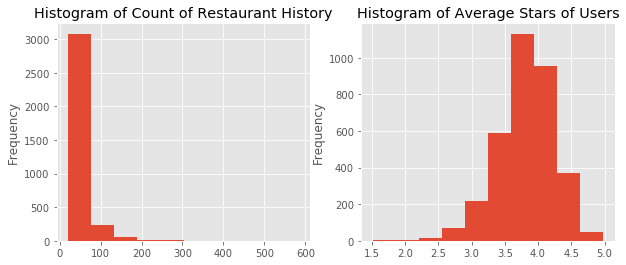

In [4]:
%matplotlib inline
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize = (10,4))
user_hist_df.history_count.plot(kind='hist', title='Histogram of Count of Restaurant History',ax = ax[0])
user_hist_df.average_stars.plot(kind='hist', title='Histogram of Average Stars of Users',ax = ax[1])

(1) The left panel shows that the review counts per user is highly skewed. Most users give reviews less than 100.   
(2) The average rating per user has a heavy left tail.

[Return to the Top](#intro)   |   [Return to Section Top](#rating)

Some first questions regarding rating-based recommendation are:
1. How to measure the similarity?
2. How many neighbors to keep?
3. How to generate items from the neighbors?

**Similarity** plays a key role in the whole procedure because 

(i) We search for neighbor(s) based on similarity;

(ii) The weight of similarity in the neighbors provide information for selecting recommended restaurants.


<a id = '3.1.1'></a>
### 3.1.1 How to measure the similarity?

Pearson correlation coefficient (PCC) based on rating is adapted to calculate _user-user_ similarity. To deal with restaurants that one user has rated but the other has not, we only consider the items that both users have rated and to do this consistently ([Michael 2013](https://grouplens.org/blog/similarity-functions-for-user-user-collaborative-filtering/)). The PCC is a mean-centered cosine similarity and defined as:

$$Sim(u,v) = \frac{\sum_{i\in I_{uv}}(r_{ui}-\mu_u)(r_{vi}-\mu_v)}{\sqrt{\sum_{i\in I_{uv}}(r_{ui}-\mu_u)^2}\sqrt{\sum_{i\in I_{uv}}(r_{vi}-\mu_v)^2}}$$

Notations:

$U$: set of all users, $u$ and $v$ denotes users.

$I$: set of all restaurants, $i$ and $j$ denotes restaurants. 

$I_{uv}$: the set of all restaurants rated by both user $u$ and $v$.

$R$: set of all ratings

$r_{ui}$: the _true_ rating of user $u$ for restaurent $i$

$\mu_{u}$: the mean of all ratings given by user $u$


<a id = '3.1.2'></a>
### 3.1.2 How many neighbors to keep?

1. Pre-Screening: 
    1. Since PCC is calculated based on co-rated items, it is necessary to set a threshold to filter out reference users that have too few co-rated items with the target user to avoid non-informative correlation for extreme cases.
    2. Intuitively strong positive correlation between two users is a good indicator that they possibly belong to the same group when negative rating correlation are less reliable for the recommending task. We decide to remove all the users that have negative PCC with the target user. After that, we also consider to set a threshold for the minimum PCC.

2. Top K filtering for prediction:

    Here we need to choose a list of the *k* nearest-neighbors for recommendation. Theoretically, the prediction accuracy of *k* is a concave function ([Francesco 2011](http://www.cs.ubbcluj.ro/~gabis/DocDiplome/SistemeDeRecomandare/Recommender_systems_handbook.pdf)). That is to say, when *k* is small, the accuracy is low, as *k* increases, more neighbors contribute to the prediction and the variance introduced by individual neighbors is averaged out. As a result, the prediction accuracy improves. Finally, the accuracy usually drops when too many neighbors are included. We will use Cross-Validation to choose the optimal *k*.
 


<a id = '3.1.3'></a>

### 3.1.3 How to generate items from the neighbors?

1. A direct way is to choose the items that the neighbors prefer. 
2. Consider we have the rating information, we can also predict the target user’s rating for the recommended items in his/her neighborhood. Then select items with high ratings.
 
The initial function for prediction is established as follows: 

$$ pred(u,i) = \frac{\sum_{v \in N_i^k(u)}sim(u,v)r_{vi}}{\sum_{v \in N_i^k(u)}sim(u,v)} \hspace{4.2cm} (1)$$

$N_i^k(u)$: the *k* nearest neighbors of user $u$ that have rated item $i$

However, users have different rating schemes, an happy user might consistently rate things 4 of 5 stars that a sad user rates 3 of 5 stars. Take this into account, we introduce the user’s mean rating to form the updated the function:

$$ pred(u,i) = \mu_{u} + \frac{\sum_{v \in N_i^k(u)}sim(u,v)(r_{vi} - \mu_{v})}{\sum_{v \in N_i^k(u)}sim(u,v)} \hspace{2cm} (2)$$

[Return to the Top](#intro)   |   [Return to Section Top](#rating)   | [Comparison](#pred_vs)

<a id = '3.1.4'></a>
### 3.1.4 Model Building and Evaluation

Now, let's implement our ideas on real data. The following module is built up based on 1 example user.

In [5]:
# select a typical user with count = median
p = np.percentile(user_hist_df.history_count, 50) # return median
print(p)
user_hist_df.loc[user_hist_df['history_count'] == 32].sample(n=1, random_state= 7)

32.0


,history_count,restaurant_history,user_id,average_stars
659,32,"[dimv16yFu0JXR1n1SAqedQ, KOQw4e1rwCY5e0RnmB5rg...",AwwV1jK46hKla2nLF2J-kA,3.38


In [6]:
target_id = 'AwwV1jK46hKla2nLF2J-kA'

In [7]:
# get this user's history
target_hist = user_hist_df.loc[user_hist_df['user_id']== target_id].copy().iloc[0]['restaurant_history']

In [8]:
# build a dataframe to save results for target_user

result_df = user_hist_df.copy()

# find overlap of reference users and target user

overlap_list = rec.overlap(target_hist,user_hist_df)
result_df['overlap'] = overlap_list

# drop the rows that has empty overlapping and user himself

result_df = result_df[result_df.astype(str)['overlap'] != '[]']
result_df = result_df[result_df.user_id != target_id]

# count the number of overlapping restaurants and add it to dataframe

overlap_count = result_df['overlap'].apply(len).tolist()
result_df['overlap_count'] = overlap_count

# filter the overlapping count >=5 , get 89 reference users
result_df = result_df.loc[result_df['overlap_count']>=5].copy()

In [9]:
# calculate pearson correlation
rho_list = []
for i in range(0,len(result_df)):
    rho_list.append(rec.corr_cal(u_id = result_df.iloc[i]["user_id"], 
                                 t_id = target_id,
                                 biz = result_df.iloc[i]["overlap"],
                                 df = AZ_review))

result_df['rho'] = rho_list    

In [10]:
# select top 5 as high correlated users , check their rho, all >0.8
# let them be the neighbors
result_df = result_df.sort_values('rho', ascending= False).copy()
nb_df = result_df.head(5)

In [11]:
# recommend the overlapping 5 star restaurants of neighbors to our target user

# get neighbor id
ref_id = list(nb_df.user_id.values)

# get 5 star restaurants that neighbor reviewed but the target user has never been to

ref_df = AZ_review.loc[(AZ_review['user_id'].isin(ref_id)) & (AZ_review['stars'] == 5)
             &(~AZ_review['business_id'].isin(target_hist))].copy()

# find those restaurants that occurs at least twice
ref_df_c = ref_df.groupby('business_id').size().reset_index(name='counts')
ref_r = ref_df_c[ref_df_c['counts'] >= 2]['business_id'].tolist()

# ref_r is the recommend list for target user 
ref_r

# get restaurant info
restaurant = pickle.load(open('az_res.pkl', 'rb'))
restaurant[restaurant['business_id'].isin(ref_r)]


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,is_restaurant
2104,5223 N Central Ave,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",cTJjTKz2huGZ-ElScC2pSw,"[American (New), Bars, Food, Pubs, Nightlife, ...",Phoenix,"{'Monday': '11:00-23:00', 'Tuesday': '11:00-23...",1,33.513575,-112.073381,Windsor,,85012,977,4.0,AZ,True
66318,110 E Roosevelt St,"{'RestaurantsTableService': True, 'GoodForMeal...",-yQHIYKXH3HAdhh1W52OMQ,"[American (New), Hot Dogs, Food, Donuts, Gastr...",Phoenix,"{'Monday': '8:00-21:00', 'Tuesday': '8:00-21:0...",1,33.458782,-112.072266,Short Leash Hotdogs & Rollover Doughnuts,,85004,413,4.0,AZ,True
99030,308 N 2nd Ave,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",Ns20WGWn6s6niKAGIQB4UQ,"[Arts & Entertainment, Music Venues, Restauran...",Phoenix,"{'Monday': '11:00-0:00', 'Tuesday': '11:00-0:0...",1,33.451778,-112.076835,Crescent Ballroom,,85003,493,4.0,AZ,True
100892,1 W Jefferson St,"{'WheelchairAccessible': True, 'DogsAllowed': ...",Gz9SlLqxS6wnxPvgdOQNrA,"[Bars, Nightlife, Lounges, Restaurants, Cockta...",Phoenix,"{'Tuesday': '16:00-2:00', 'Friday': '16:00-2:0...",1,33.446995,-112.073873,Bitter & Twisted Cocktail Parlour,,85003,683,4.0,AZ,True
145578,1513 E Apache Blvd,"{'RestaurantsTableService': True, 'GoodForMeal...",2GmGT-7QjowR1ihup3FbVA,"[Restaurants, Mediterranean, Grocery, Middle E...",Tempe,"{'Monday': '11:00-20:00', 'Tuesday': '11:00-20...",1,33.414271,-111.913451,Haji-Baba,,85281,720,4.5,AZ,True
148677,7213 E 1st Ave,"{'RestaurantsTableService': True, 'GoodForMeal...",sKrlmbrZWCyLIgiMihCPqw,"[Hawaiian, Restaurants, Pan Asian]",Scottsdale,"{'Monday': '11:00-22:00', 'Tuesday': '11:00-22...",1,33.493853,-111.925625,Hula's Modern Tiki Scottsdale,,85251,509,4.0,AZ,True
163683,110 E Roosevelt St,"{'RestaurantsTableService': False, 'GoodForMea...",9Cq_NVvWZOEAzmE7tqJgmg,"[Restaurants, Hot Dogs, American (New), Food S...",Phoenix,"{'Monday': '8:00-21:00', 'Tuesday': '8:00-21:0...",1,33.458919,-112.072201,Short Leash Hot Dogs Food Truck,,85004,401,4.5,AZ,True
169376,4404 N Central Ave,"{'Alcohol': 'beer_and_wine', 'HasTV': False, '...",lgWB0yGXpZvupYREWxtV7g,"[Sandwiches, Italian, Pizza, Restaurants]",Phoenix,"{'Monday': '11:00-15:00', 'Tuesday': '11:00-15...",1,33.500621,-112.074311,Pane Bianco,,85012,479,4.0,AZ,True
171047,603 N 5th Ave,"{'Alcohol': 'beer_and_wine', 'HasTV': True, 'N...",9a3DrZvpYxVs3k_qwlCNSw,"[Sandwiches, Pizza, Restaurants, Italian]",Phoenix,"{'Monday': '11:00-21:00', 'Tuesday': '11:00-22...",1,33.454960,-112.079908,Cibo,,85003,1698,4.5,AZ,True


**Result Analysis**
- The average stars for the recommended restaurants all greater than 4.0, this confirms the quality of the restaurant.
- We obtained various types of restaurant, e.g. American(new), Arts & entertainment, bars, fast food, which is also encouraging.

Next, we use MAE & RMSE based on Cross-Validation to Evaluate the model performace. 

$$ MAE = \frac{1}{N_{I_u}}\sum|r_{ui} - pred(u,i)|$$

$$ RMSE = \sqrt{\frac{1}{N_{I_u}}\sum(r_{ui} - pred(u,i))^2}$$

$I_u$ stands for all restaurants rated by user $u$. We firstly hold out 1 item $a \in I_u$, then update $I_u$ as $I_u - a$, get $pred(u,a)$ and iterate this procedure for all the restaurants in $I_u$, then calculate the MAE and RMSE for the prediction. Our goal is to minimize these two criteria.

In [12]:
def get_result(u_id, co_rate, k):
    target_id = u_id
    
    # creat a nested list to save the result
    result = []
    
    # get this user's history as a list
    r_hist = user_hist_df.loc[user_hist_df['user_id']== target_id].copy().iloc[0]['restaurant_history']
  
    n = len(r_hist)
    for i in range(0, n): 
        
        # mask ith item
        r_hist_maski = r_hist[:i] + r_hist[i+1:]

        # filter other users that have been to the masked item, create a dataframe to save info
        # call them reference users
        r_hist_maski_check_df = user_hist_df.copy()
        r_hist_maski_check_df = r_hist_maski_check_df[r_hist_maski_check_df['restaurant_history'].apply(lambda x: r_hist[i] in x)] 
        

        # drop the user itself
        r_hist_maski_check_df = r_hist_maski_check_df[r_hist_maski_check_df.user_id != target_id]

        # for each reference user, find the co-rate restaurant with target user
        
        overlap_list = rec.overlap(r_hist_maski,r_hist_maski_check_df)        
        r_hist_maski_check_df['overlap'] = overlap_list

        # drop the rows that has empty overlapping
        
        r_hist_maski_check_df = r_hist_maski_check_df[r_hist_maski_check_df.astype(str)['overlap'] != '[]'].copy()


        # count the number of co-rate restaurant for each reference user, save it
        overlap_count = r_hist_maski_check_df['overlap'].apply(len).tolist()
        
        r_hist_maski_check_df['count'] = overlap_count
        
        # filter the overlapping count >= count_filter(integer), given in the function

        r_hist_maski_check_df = r_hist_maski_check_df.loc[r_hist_maski_check_df['count']>= co_rate].copy()

        # calculate correlation with all the potential reference user
        
        rho_list = []
        for j in range(0,len(r_hist_maski_check_df)):
            rho_list.append(rec.corr_cal(u_id = r_hist_maski_check_df.iloc[j]["user_id"], 
                                     biz = r_hist_maski_check_df.iloc[j]["overlap"],
                                     t_id = target_id,
                                    df = AZ_review))
        r_hist_maski_check_df['rho'] = rho_list
        
        # select k neighbors

        r_hist_maski_check_df = r_hist_maski_check_df.sort_values('rho',ascending= False).copy().head(k)
        r_hist_maski_check_df = r_hist_maski_check_df.loc[r_hist_maski_check_df['rho']>0].copy()
        
        
        if len(r_hist_maski_check_df) == 0:
            pred = restaurant[restaurant['business_id'] == r_hist[i]].iloc[0]['stars']
        else:
            
            # get the reference users'rate for the masked restaurant
            score_l = []
            for j in range(0,len(r_hist_maski_check_df)):
                score_l.append(rec.get_score(u_id = r_hist_maski_check_df.iloc[j]["user_id"],
                                         biz = r_hist[i],
                                          df = AZ_review))
            r_hist_maski_check_df['score'] = score_l

            ###### calculate pred score######

            # equation 3, adjust average rate info

            # get the target_user score for the mask item

            target_mask_score = rec.get_score(u_id = target_id, biz = r_hist[i], df = AZ_review )

            # get avg score of target_user before remove the mask item 

            target_avg_score = rec.get_avg_score(u_id = target_id, df = user_hist_df)

            # remove the impact of the score that target user give for the mask item

            target_avg_score_update = (target_avg_score * len(r_hist) - target_mask_score)/(n-1)

            # calculate the modified prediction score

            pred = target_avg_score_update + sum(r_hist_maski_check_df.rho * (r_hist_maski_check_df.score -r_hist_maski_check_df.average_stars))/sum(r_hist_maski_check_df.rho)
        
        # save the prediction score  and the true score into a list 
        
        pred_i = [pred, target_mask_score]
        
        result.append(pred_i)
    return result

In [13]:
########## Take 2-3 minutes to run this line ########################
#sample_result = get_result(u_id = target_id, co_rate = 2, k = 10)  #
#pickle.dump(sample_result, open('sample_result.pkl', 'wb'))#########
sample_result = pickle.load(open('sample_result.pkl', 'rb'))

In [14]:
# calculate mae and rmse
# mae 
mae_sample = (1/32) * sum([abs(item[0]- item[1]) for item in sample_result])
mae_sample

0.8740275294276727

In [15]:
# rmse

rmse_sample = m.sqrt((1/32) * sum([(item[0]- item[1])**2 for item in sample_result]))
rmse_sample

1.0754111033208529

**Comments:**

1. This method can be generated for each user in the dataset: given a `user_id`, we can get the prediction result for him/her. However, to do this through foo-loop will be time and memory consuming. Ideally, we should split the whole dataset into train set and test set and build up our model on the train set then check it's performance on the test set.
2. We still need to decide the parameter such as number of co-rating restaurants, number of neighbors based on parameter tuning.

We will borrow the power of python-package: `Surprise` that developed by *Nicolas*, etc. for the following analysis. Thanks to these genious! We can perform the model selection procedure much moooore efficiently now!

[Return to the Top](#intro)   |   [Return to Section Top](#rating)

<a id = '3.1.5'></a>
### 3.1.5 Model Selection by Parameter Tuning

In [16]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise import KNNBasic
from surprise import KNNWithMeans

-  Data preparation, split into trainset(75%) and test set(25%).

In [17]:
AZ_star = pickle.load(open('AZ_star.pkl', 'rb'))
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(AZ_star[['user_id', 'business_id', 'stars']], reader)

In [18]:
import random
random.seed(7)
# split into train and test

raw_ratings = data.raw_ratings

# shuffle ratings
random.shuffle(raw_ratings)

# 75% trainset, 25% testset                                                
threshold = int(.75 * len(raw_ratings))                                     
trainset_raw_ratings = raw_ratings[:threshold]                             
test_raw_ratings = raw_ratings[threshold:]                                 

# trainset
data.raw_ratings = trainset_raw_ratings 
trainset = data.build_full_trainset()         
# testset
testset = data.construct_testset(test_raw_ratings)    

<a id = 'pred_vs'></a>
-  Comparision of Prediciton Rating between the different prediction functions (1) and (2)

[link to the function](#3.1.3)

In [19]:
# knn-basic with default setting

algo = KNNBasic(sim_options = {'name': 'pearson',
                                  'user_based': True})
algo.fit(trainset)
predictions = algo.test(testset)

# RMSE
accuracy.rmse(predictions)
# MAE
accuracy.mae(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1459
MAE:  0.8936


0.89363636417558046

In [20]:
# knn-mean with default setting
algo = KNNWithMeans(sim_options = {'name': 'pearson',
                                  'user_based': True})
algo.fit(trainset)
predictions = algo.test(testset)

# RMSE
accuracy.rmse(predictions)
# MAE
accuracy.mae(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0801
MAE:  0.8299


0.82991971758888372

**Comments:**

1. The Result above verified that it is neccessary to adjust user's personal rating scheme. By doing that, we improved both the RMSE and MAE. We will carry on the analyis based on method 2.

2. Also, the previous analysis used the default setting, such as `min_support` = 1(lower limit of co-rating restaurants), `min_k` = 1 (lower limit of neighbours), and `k` = 40. We will use the famous *GridSearchCV* to do the parameter tuning.

- Use *k* = 40, find best `min_k` and `min_support`

In [22]:
# try parameter tuning for KNNWithMeans, use k = 40 
#################################
### running time: 5-10 min   ####
#################################
from surprise.model_selection import GridSearchCV
param_grid = {'k': [40],    # default setting,
              'min_k': [1,3,5,10,15], # try different minimum number of neighbors,
              'sim_options': {'name': ['pearson'],
                              'min_support': [1,3,5], # try different minumber number of co-rates,
                              'user_based': [True]
                             }
             }

# tune parameter
# gs = GridSearchCV(KNNWithMeans, param_grid, measures = ['rmse','mae'], cv=5)

# gs.fit(data) # here data is already switch to trainset by data.raw_ratings = trainset_raw_ratings 

# # print best score
# print(gs.best_score)

# # combination of parameters that gave the best RMSE score
# print(gs.best_params)

# save the result into dataframe
#choose_min_k_support = pd.DataFrame.from_dict(gs.cv_results)

#pickle.dump(choose_min_k_support, open('choose_min_k_support.pkl', 'wb'))

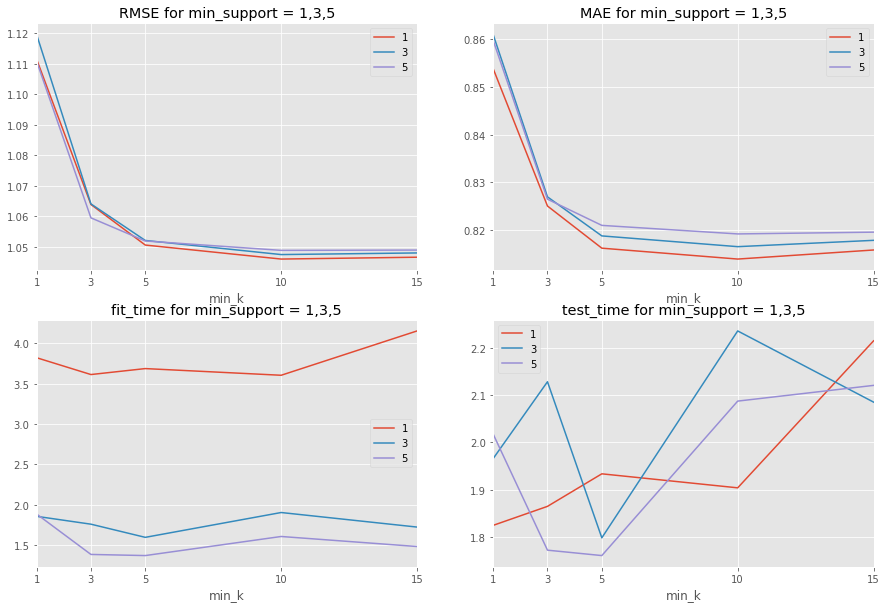

In [23]:
# plot the rmse and mse
choose_min_k_support = pickle.load(open('choose_min_k_support.pkl', 'rb'))
cv_info = choose_min_k_support[['mean_fit_time','mean_test_time','mean_test_mae','mean_test_rmse',
                              'param_k','param_min_k','param_sim_options']].copy()
cv_info = pd.concat([cv_info.drop(['param_sim_options'], axis=1), cv_info['param_sim_options'].apply(pd.Series)], axis=1).drop(['name','user_based'],axis = 1)
cv_info.set_index('param_min_k', inplace=True)
g = cv_info.groupby('min_support')

fig, ax = plt.subplots(2,2,figsize=(15,10))
g['mean_test_rmse'].plot(legend=True, ax = ax[0,0], title = 'RMSE for min_support = 1,3,5')
g['mean_test_mae'].plot(legend=True, ax = ax[0,1], title = 'MAE for min_support = 1,3,5')
g['mean_fit_time'].plot(legend=True, ax = ax[1,0], title = 'fit_time for min_support = 1,3,5')
g['mean_test_time'].plot(legend=True, ax = ax[1,1], title = 'test_time for min_support = 1,3,5')
ax[0,0].set(xlabel ="min_k", xticks = [1,3,5,10,15])
ax[0,1].set(xlabel = "min_k", xticks = [1,3,5,10,15])
ax[1,0].set(xlabel = "min_k", xticks = [1,3,5,10,15])
ax[1,1].set(xlabel = "min_k", xticks = [1,3,5,10,15])
plt.show()


**Comments:**
1. From the top two graphs, we could see that as the number of min_neighbors for prediction increases, both the MAE and RMSE decrease, and reach to the smallest value when `min_k` = 10.
2. `min_support` = 1 gives the best performance, however the training time for it is the maximum, we can see from the left bottom plot. That is because the algorithm is applied to every pair of users as long as they have 1 co-rating restaurant. It is interesting that the test time for it is acceptable short when `min_k` = 10. 
3. We want to balance the performance of the model and the resource efficency. Thus we will choose `min_k` = 10 and `min_support` =1, then try to find the optimal *k* (upper limit of the neighbors).

In [24]:
# select min_k = 10, min_support = 1, find optimal k
from surprise.model_selection import GridSearchCV
# param_grid = {'k': list(np.arange(5,60,step = 5)),    
#               'min_k': [10], 
#               'sim_options': {'name': ['pearson'],
#                               'min_support': [1],
#                               'user_based': [True]
#                              }
#              }

# # tune parameter
# gs = GridSearchCV(KNNWithMeans, param_grid, measures = ['rmse','mae'], cv=5)

# gs.fit(data) # here data is already switch to trainset by data.raw_ratings = trainset_raw_ratings 

# # save the result into dataframe
# choose_k = pd.DataFrame.from_dict(gs.cv_results)


# pickle.dump(choose_k, open('choose_k.pkl', 'wb'))

In [25]:
choose_k = pickle.load(open('choose_k.pkl', 'rb'))
choose_k = choose_k[['mean_fit_time','mean_test_time','mean_test_mae','mean_test_rmse',
                     'param_k','param_min_k','param_sim_options']].copy()
choose_k = pd.concat([choose_k.drop(['param_sim_options'], axis=1), choose_k['param_sim_options'].apply(pd.Series)], axis=1).drop(['name','user_based'],axis = 1)

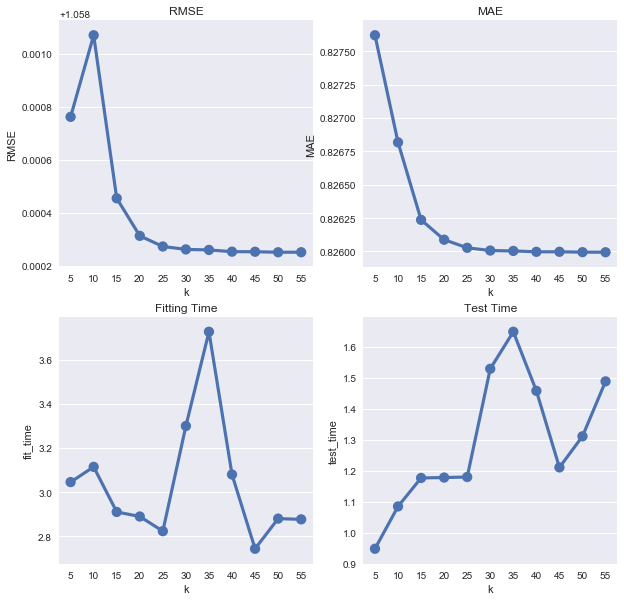

In [26]:
import matplotlib.pyplot as plt
import seaborn as s
fig, ax = plt.subplots(2,2,figsize=(10,10))
s.pointplot(x="param_k", y="mean_test_rmse", data=choose_k, ax = ax[0,0])
s.pointplot(x="param_k", y="mean_test_mae", data=choose_k, ax = ax[0,1])
s.pointplot(x="param_k", y="mean_fit_time", data=choose_k, ax = ax[1,0])
s.pointplot(x="param_k", y="mean_test_time", data=choose_k, ax = ax[1,1])
ax[0,0].set(xlabel='k', ylabel='RMSE',title = 'RMSE')
ax[0,1].set(xlabel='k', ylabel='MAE', title = 'MAE')
ax[1,0].set(xlabel='k', ylabel='fit_time', title = 'Fitting Time')
ax[1,1].set(xlabel='k', ylabel='test_time', title = 'Test Time')

**Comments:**
1. RMSE and MAE decrease as `k` increases and tends to be stable after `k` = 40. 
2. The fitting time reaches to maximum when `k` = 35, but then decreases again, similar behavior is shown for the test time.
3. Again, consider both the accuracy and efficiency, we decide to keep the default setting `k` =40. And our final model for the train set is `k ` = 40, `min_k` =10, `min_support` = 1.

In [27]:
# choose k = 40, min_k  = 10
algo = KNNWithMeans(k = 40,
                    min_k = 10,
                    sim_options = {'name': 'pearson',
                                  'user_based': True})
algo.fit(trainset)
predictions = algo.test(testset)

# RMSE
accuracy.rmse(predictions)
# MAE
accuracy.mae(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0387
MAE:  0.8062


0.80623245193251891

Compared to the default setting, we decrease the the RMSE from 1.0801 to 1.0452, and the MAE from 0.8299 to 0.8155. The prediction result is summarized below.


<a id = '3.1.6'></a>
### 3.1.6 Discussion about Rating-based Recommendation System

So far, we use user's rating as the feature for neighborhood selection, and this method requires co-rating restaurants for similarity calculation. The recommendation system we built can be useful for the residents live in Arizona, which is good, but what about those travelers that never been to Arizona before? It is highly possible that these users have no co-rating restaurants with the users lived in Arizona. Then our recommendation system might not work for them. To overcome this geographical limit in our system, we propose other methods that not relied on the co-rating. 

Yelp dataset not only gives the rating of the user, but also offers user's text review about the restaurant. Our idea is to concatenate all the text reviews for each user, then perform topic modeling to cluster these users into different groups. Also, the restaurants have different features, by analyzing these features, we are able to perform clustering too. Consider that text reviews and the business categories are have different properties when applied to the user similarity analysis, we decide to perform both clustering seperately.


[Return to the Top](#intro)   |   [Return to Section Top](#rating)

<a id = '3.2'></a>

## 3.2 Topic modeling of Review Data

Our topic modeling is focusing on customers preferred similar features and group them together to make a recommendation. Thus, we will only do text mining in good reviews.

In [28]:
import numpy as np
import json
import pandas as pd
import ast
import csv
import matplotlib.pyplot as plt
from __future__ import print_function
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction import text
import nltk
nltk.download('stopwords')
nltk.download('punkt') # tockenizer
import re
import string
from nltk.stem import WordNetLemmatizer
from contractions2 import CONTRACTION_MAP
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import re
from urllib import request
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
import collections
from sklearn.metrics import silhouette_samples, silhouette_score
wnl = WordNetLemmatizer()


#################################################
# Cleaning all the review history, it will take # 
# about 10 hours, we have save the clean text   #
# into a pickle called text.pkl                 #
#################################################


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wangqi.shania/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wangqi.shania/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<a id = '3.2.1'></a>
### 3.2.1 Review data pre-possessing

In [29]:
user_review = pickle.load( open( "r20_dfh.pkl", "rb" ) )
text = pickle.load(open ('text.pkl', 'rb'))

In [30]:
# Applying TF-IDF which penalize too low and high frequency terms
tfidf_vectorizer = TfidfVectorizer(max_df=0.95,min_df=0.05)
tfidf = tfidf_vectorizer.fit_transform(text)

In [31]:
# Get the words (feature names)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
tfidf_feature_names1 = [text.replace(" ", "_") for text in tfidf_feature_names]

In [32]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def get_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

<a id = '3.2.2'></a>
### 3.2.2 NMF- Topic Modeling

In [33]:
# constructing NMF model with 5 bases
nmf5 = NMF(n_components=5, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print_top_words(nmf5, tfidf_feature_names1, 16)

Topic #0:
order just come sauce make chicken cheese fry eat say flavor think burger know want little
Topic #1:
come dish restaurant order noodle flavour definitely rice really taste chicken soup ramen sushi favourite price
Topic #2:
love delicious come really definitely order amazing husband friendly awesome amaze best favorite super chicken staff
Topic #3:
beer bar restaurant menu excellent nice price make best staff friendly selection really drink wine just
Topic #4:
le la pour au plat par plus café pas vega restaurant cuisine décor montreal poutine son



In [34]:
# constructing NMF model with 5 bases
nmf10 = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print_top_words(nmf10, tfidf_feature_names1, 16)

Topic #0:
really just say think pretty eat know thing make come love want little people pizza look
Topic #1:
dish flavour come noodle really restaurant favourite rice definitely ramen taste sushi soup price pork pretty
Topic #2:
love delicious husband amazing favorite amaze really definitely yummy super friendly best awesome staff salad fresh
Topic #3:
menu make restaurant table just dish meal wine serve visit enjoy experience salad order bar know
Topic #4:
chicken sauce order cheese fry flavor salad burger fresh beef onion sandwich pork rice potato sweet
Topic #5:
le la pour au plat par plus café pas restaurant montreal décor poutine cuisine son carte
Topic #6:
excellent wife friendly price staff best pizza restaurant nice clean fresh lunch quality location burger chicken
Topic #7:
order come definitely wait server table seat drink friend friendly decide minute location boyfriend busy chicken
Topic #8:
vega la buffet strip best sushi steak casino favorite restaurant crab hotel town fl

- Comparing NMF 5 topics and 10 topics, we found all 5 topics are unique, which may indicate some information are hiding within some topics. For ten topics, there are some overlaping in between, thus, we use 8 topic models

<a id = '3.2.3'></a>
### 3.2.3 LDA - Topic Modeling and Comparison with NMF

In [35]:
# In this case, we are comparing NMF model with LDA model with 8 topics
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=0.05)
tf = tf_vectorizer.fit_transform(text)
lda8 = LatentDirichletAllocation(n_topics=8, max_iter=5,
                                learning_method='online',
                                learning_offset=50.)
lda8.fit(tf)
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda8, tf_feature_names, 16)


Topics in LDA model:
Topic #0:
sauce dish cheese make order sweet flavor serve menu salad just bread dessert fresh restaurant meal
Topic #1:
come order restaurant dish really chicken definitely taste price rice make noodle just pretty bit nice
Topic #2:
love delicious really come order definitely just make drink amazing nice friendly super wait friend little
Topic #3:
just make know say come think eat thing order really want look pretty little people way
Topic #4:
restaurant menu bar best price make beer staff friendly nice experience excellent selection atmosphere location spot
Topic #5:
la le vega pour au restaurant plus menu plat casino par buffet table strip hotel café
Topic #6:
order chicken lunch come nice pizza salad cheese fry table burger restaurant meal menu really sandwich
Topic #7:
chicken order come love sauce best just flavor fry eat really favorite make fresh rice taste



- From the result in LDA model, there are still some overlaping in topics. 

In [36]:
def non_negative_marix_decomp(n_components,train_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, 
                     init='nndsvda', max_iter=500, 
                     random_state=0)
    W = model.fit_transform(train_data)
    H = model.components_
    nmf = (W,H)
    return(nmf)

In [37]:
w8,h8 = non_negative_marix_decomp(8,tfidf.T)
h8 /= h8.sum(0)

In [38]:
feature_names = [text.replace(" ", "_") for text in tfidf_feature_names]
num_top_words = 16
num_topics = 8
word_topic = w8
fontsize_base = 15# / np.max(word_topic) # font size for word with largest share in corpus

for t in range(0, num_topics):
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = [feature_names[k] for k in top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    print('# Topic', t)
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        print(word, share)
    print('\n')

# Topic 0
really 1.41417258906
just 1.3686202941
pretty 0.82807155324
say 0.787461291706
think 0.760703452868
eat 0.723111802433
know 0.711847936942
thing 0.692081462227
make 0.655823651154
come 0.610900639201
want 0.594714535434
little 0.585531904526
people 0.487510909284
pizza 0.475623271735
love 0.452902267934
star 0.436266425666


# Topic 1
dish 1.08261010797
flavour 0.889778855697
come 0.860583347439
noodle 0.860035388494
restaurant 0.846584560386
really 0.744332378163
ramen 0.656655014497
favourite 0.639844970853
rice 0.635088754856
taste 0.627306566719
definitely 0.612433759835
sushi 0.606471991652
soup 0.588782586574
bit 0.54273329489
pork 0.524555467653
price 0.522394366521


# Topic 2
love 2.25513457147
delicious 1.40411677045
really 0.813258928421
amazing 0.775621010182
husband 0.691783844934
definitely 0.679550366874
amaze 0.620269408468
favorite 0.608172127066
super 0.582244752039
awesome 0.545467172752
friendly 0.534746818668
yummy 0.523611711098
come 0.487043438624
best 

- In comparison with LDA 8 topic model, NMF gives distinct models. Thus, we prefer to use NMF for our topic modeling. We will use NMF model to cluster all users. We focus on the H matrix, which includes each user's weight for 8 topics, applying hierarchical clustering method.

<a id = '3.2.4'></a>
### 3.2.4 Clustering Based on NMF

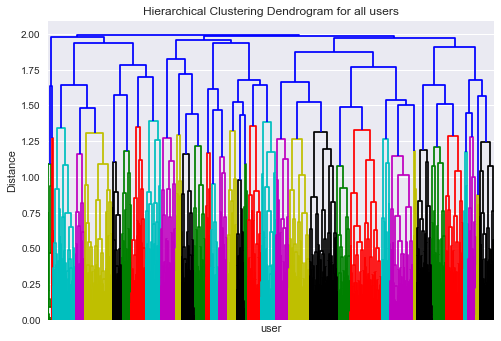

In [39]:
Z = linkage(h8.T,method='complete',metric='correlation') # transpose the H matrix

plt.title('Hierarchical Clustering Dendrogram for all users')
plt.xlabel('user')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,
    no_labels = True# font size for the x axis labels
)
plt.show()

In [40]:
no_max_clust = 8 
cluster_id = fcluster(Z,no_max_clust,criterion='maxclust')

In [41]:
w20,h20 = non_negative_marix_decomp(20,tfidf.T)

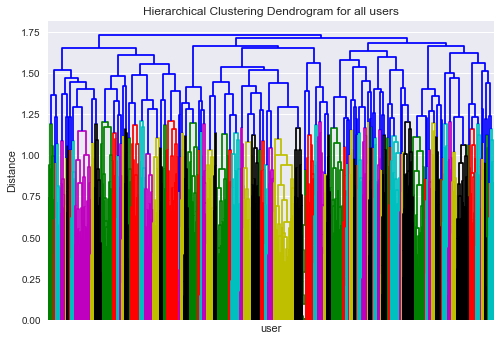

In [42]:
Z2 = linkage(h20.T,method='complete',metric='correlation') # transpose the matrix

plt.title('Hierarchical Clustering Dendrogram for all users')
plt.xlabel('user')
plt.ylabel('Distance')
dendrogram(
    Z2,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,
    no_labels = True# font size for the x axis labels
)
plt.show()
no_max_clust = 20
cluster_id2 = fcluster(Z2,no_max_clust,criterion='maxclust')
labels2 = np.argmax(h20,axis = 0)

In [43]:
counter=collections.Counter(cluster_id)
print(counter)

Counter({7: 5111, 8: 2825, 2: 2180, 6: 1758, 3: 1753, 4: 1638, 5: 791, 1: 179})


In [44]:
counter=collections.Counter(cluster_id2)
print(counter)

Counter({2: 1441, 9: 1343, 7: 1217, 4: 1181, 17: 1097, 3: 979, 16: 968, 6: 942, 18: 908, 8: 899, 5: 763, 12: 713, 11: 565, 14: 535, 15: 519, 1: 483, 20: 474, 19: 471, 10: 446, 13: 291})


In [45]:
silhouette_score(tfidf, cluster_id)

0.0039983336743475064

In [46]:
silhouette_score(tfidf, cluster_id2)

-0.0064869655208650455

By comparison between the silhouette score, the 8 clusters give a smaller silhouette score than 20 clusters, which means 8 cluster is more suitable than 20. From the distribution of 8 clusters above, we found the lagest cluster have more than 5000 users, while the minority group has only 179 users. Next, we will assign labels to users. Users with the same label belong to the same cluster.

[Return to the Top](#intro)   |   [Return to Section Top](#textmining)

In [47]:
user_review['cluster'] = cluster_id
file = user_review.sort_values(by='cluster')
file.head()

,review_history,user_id,review,cluster
12259,[I love weiners! The pastrami is pretty good t...,k1FxBPNVosnWJHttRNdvPQ,I love weiners! The pastrami is pretty good to...,1
11726,[Bon restaurant grec avec un décor méditerrané...,hv2FYLSr351y_XhXRXlmuQ,Bon restaurant grec avec un décor méditerranée...,1
2868,"[OO que oui,c'est une belle boulangerie que c'...",9xM8upr_n9jchUDKxqSGHw,"OO que oui,c'est une belle boulangerie que c'e...",1
8831,[Une belle surprise juste à côté de chez moi. ...,XOgqs74hkbXT54mSp7JMRA,Une belle surprise juste à côté de chez moi. E...,1
5823,"[Bon resto indien, bon rapport qualité / prix ...",La1ggB37gvq6UWpEWaMtMA,"Bon resto indien, bon rapport qualité / prix !...",1


<a id = '3.3'></a>

## 3.3 K-modes Clustering

In this part of the analysis, we are focusing on the attributes of each restaruant. Yelp also collects features from restaruants like whether they offer Wi-Fi and are these place good for kids. These attributes are also factors that people want to look at when finding a suitable restaruant. Here, we will be clustering yelp users based on their favorite features. Then recommend them people to ask and restaurants to go to based on the features they like and location they are at. 

For each reviewer, we choose their favorite feature based on the statistic - mode. All features in the dataset is categorical. As we attempt clustering method like K-Mean and Hierarchical cluster method the process and result are not interpretable. Thus, we turned to a cluster method made just for dataset with only categorical variables - K-Mode Cluster Method. Using this method, we created 6 clusters of reviewers based on all these features. Finally, we are using the cluster as a class, combining with location of the user, to give recommendation of restaurants.

In [3]:
##b_business contains only restaurant in US
b_business = pickle.load(open('b_businesso.pkl', 'rb'))
##r_review 320:
##reivews more than 3 stars
##users more than 20 reviews
##no text review
r_review320 = pickle.load(open('r_review320.pkl', 'rb'))

In [4]:
#clean up review data
r_review320 = r_review320.drop(['cool','funny','stars','useful'],axis=1).copy()

In [5]:
r_review320.head()

,business_id,date,review_id,user_id
7,9_CGhHMz8698M9-PkVf0CQ,2012-05-11,ymAUG8DZfQcFTBSOiaNN4w,u0LXt3Uea_GidxRW1xcsfg
9,5r6-G9C4YLbC7Ziz57l3rQ,2013-02-09,w41ZS9shepfO3uEyhXEWuQ,u0LXt3Uea_GidxRW1xcsfg
12,XWTPNfskXoUL-Lf32wSk0Q,2011-09-28,PdZ_uFjbbkjtm3SCY_KrZw,u0LXt3Uea_GidxRW1xcsfg
14,RtUvSWO_UZ8V3Wpj0n077w,2012-12-03,lsoSqIrrDbQvWpMvsSj2xw,u0LXt3Uea_GidxRW1xcsfg
15,Aov96CM4FZAXeZvKtsStdA,2010-07-16,23eqwlZzCWZkADWfd9atZw,u0LXt3Uea_GidxRW1xcsfg


<a id = '3.3.1'></a>
### 3.3.1 First Feature Selection

In the original business dataset, the attribute is in a single column; Here we are expanding the attribute variable into a dataframe, resulting in the following dataset. There are tons of information in the attribute dataset. The first round of feature selection is to keep the factors that are related to a restaurant. Other unrelavant variables are removed. 

In [6]:
#filter out unneccessary info, address,latitue, longetude,name,neighborhood,postal code
business = b_business[['business_id','state']].copy()

#get attribute as an own dictionary and then to a dataframe
attribute_o = b_business['attributes']
attribute_pd = pd.DataFrame(attribute_o)

#expand attribute to a dataframe
#takes a bit longer to run (about 1 min)
attribute = pd.DataFrame.from_dict({(i,j): attribute_pd[i][j] 
                           for i in attribute_pd.keys() 
                           for j in attribute_pd[i].keys()},
                       orient='index')

In [7]:
#Filter out useful info in attribute
att = ['Alcohol', 'HasTV','NoiseLevel','RestaurantsAttire','BusinessAcceptsCreditCards',
 'RestaurantsGoodForGroups','Caters','WiFi','RestaurantsReservations','BikeParking','RestaurantsTakeOut',
 'GoodForKids', 'HappyHour','OutdoorSeating', 'RestaurantsPriceRange2','RestaurantsDelivery','Smoking','DriveThru',
 'WheelchairAccessible', 'DogsAllowed', 'Open24Hours', 'ByAppointmentOnly',
 'RestaurantsCounterService', 'AgesAllowed']
attribute = attribute[att]
#attribute.head()

#solve multi index problem
attribute = pd.DataFrame(attribute.to_records())
#attribute.head()

attribute = attribute.set_index('level_1')
#attribute.head()
#attin = attribute.index.tolist()

In [8]:
#merge two dataset
df = pd.concat([business, attribute], axis=1)
df = df.drop(['level_0'],axis=1)
df.head()

,business_id,state,Alcohol,HasTV,NoiseLevel,RestaurantsAttire,BusinessAcceptsCreditCards,RestaurantsGoodForGroups,Caters,WiFi,...,RestaurantsPriceRange2,RestaurantsDelivery,Smoking,DriveThru,WheelchairAccessible,DogsAllowed,Open24Hours,ByAppointmentOnly,RestaurantsCounterService,AgesAllowed
4,PfOCPjBrlQAnz__NXj9h_w,OH,full_bar,True,average,casual,True,True,False,free,...,2.0,False,outdoor,False,NaN,NaN,NaN,NaN,NaN,NaN
14,fNMVV_ZX7CJSDWQGdOM8Nw,NC,NaN,False,NaN,casual,True,True,NaN,free,...,1.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,Gu-xs3NIQTj3Mj2xYoN2aw,ON,full_bar,False,average,casual,True,True,True,no,...,2.0,False,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
25,1K4qrnfyzKzGgJPBEcJaNQ,ON,full_bar,True,loud,casual,NaN,True,NaN,free,...,2.0,False,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,Dj0S-Oe4ytRJzMGUPgYUkw,OH,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id = '3.3.2'></a>
### 3.3.2 Missing Values and  Second Round of Variables Selection

The next goal is to combine the review data and attribute data using the Business ID. First we want to solve some missing value problems. The attributes are not mandatory feature for a business or customer to enter on Yelp. Therefore, missing value definately exist. The missingness of the variables ranges from 0.52% missing to 80% missing. Our solutions for variables with different percentage missing are as follow:
1. Variables that have more than 40% missing are removed beacause there are too much uncertainty. 
2. One interesting finding is that for some variables like WiFi and Alcohol,even though more than 20% are missing, the missing values seem to be missing for a reason. Therefore, these varibles are not removed and NA's are made into its own category. 
4. For other variables with only small percentage missing, we are filling in with mode. Filling them with mode won't affect too much on distribution of the variable since they only have a small portion missing.

Finally, for clustering purpose, we are condensing the data from multiple observarion per user to one observation per user. Since all the attributes are categorical, our method to condense the data to one line per user is group by users and find the mode in each variable. For example One user has input as the table shown. 

User ID       | WiFi
------------- | -------------
23            | Free
23            | Free
23            | Unknwon
23            | none
23            | Free

We ar condensing the observation for this user to:

User ID       | WiFi
------------- | -------------
23            | Free

Same for other features and users.


In [9]:
##replace missing value with mode
#df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
##replace missing value with UNKNOWN, seems more interesting for given stats
##from the statistics of each variable, it seems like NA is there for a reason
df.WiFi = df.WiFi.astype(object).fillna("UNKNOWN")
df["Alcohol"] = df["Alcohol"].astype(object).fillna("UNKNOWN")
df["NoiseLevel"] = df["NoiseLevel"].astype(object).fillna("UNKNOWN")
df["RestaurantsPriceRange2"] = df["RestaurantsPriceRange2"].fillna((df['RestaurantsPriceRange2'].median()))

##replace missing value with mode
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))


In [10]:
# Merge two files
userdf = r_review320.merge(df, left_on='business_id', right_on='business_id', how='outer')

In [11]:
## Remove restaruant that does not have a review in this set 
## total of 3885 restaruants
userdf = userdf[pd.notnull(userdf['user_id'])]

#drop the columns with too much missing values
userdf2 = userdf.drop(['business_id','date', 'review_id', 'AgesAllowed',
                               'RestaurantsCounterService','ByAppointmentOnly','HappyHour','Smoking','DriveThru','WheelchairAccessible',
                               'DogsAllowed','Open24Hours','Caters'],axis=1).copy()

In [58]:
####################################
# Way to much time                 #
# Saved into a pickle file         #
####################################

#userdfname = userdf2.groupby(['user_id']).agg(lambda x:x.value_counts().index[0])
#pickle.dump(userdfname, open('userdfname.pkl', 'wb'))

- The final data

In [12]:
#Load in the extracted data
userdfname = pickle.load(open('userdfname.pkl', 'rb'))
userdfname.head()

,state,Alcohol,HasTV,NoiseLevel,RestaurantsAttire,BusinessAcceptsCreditCards,RestaurantsGoodForGroups,WiFi,RestaurantsReservations,BikeParking,...,AcceptCreditCardn,GoodForGroupsn,WiFin,Reservationn,BikeParkingn,TakeOutn,GoodForKidsn,Outdoorn,Deliveryn,ID
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,NV,full_bar,True,average,casual,True,True,no,True,True,...,1,1,2,1,1,1,1,1,0,0
--2HUmLkcNHZp0xw6AMBPg,AZ,none,False,average,casual,True,True,free,False,True,...,1,1,1,0,1,1,1,1,0,1
--BumyUHiO_7YsHurb9Hkw,ON,none,False,average,casual,True,True,free,False,True,...,1,1,1,0,1,1,1,1,0,2
--Qh8yKWAvIP4V4K8ZPfHA,ON,full_bar,False,average,casual,True,True,no,True,True,...,1,1,2,1,1,1,1,0,0,3
--RlSfc-QmcHFGHyX6aVjA,NV,none,True,average,casual,True,True,free,False,True,...,1,1,1,0,1,1,1,0,0,4


[Return to the Top](#intro)   |   [Return to Section Top](#3.3)

<a id = '3.3.3'></a>
### 3.3.3 Clustering Method: K-modes Cluster

Another way to select feature we want to use for a k-mode cluster is to look at the centroid after clustering.
The centroid will look like the table below.

So it would be easy to indentify which variable we don't need. For instance, The variable HasTV is the always True in all of the cluster (no matter how many clusters we decide); it won't make a difference.

After testing out different numbers of clustering, we removed the following variables because they always obtain the same value in the cluster centroids. 

- HasTV
- BusinessAcceptsCreditCards
- BikeParking
- NoiseLevel
- Restaurant Attire

The mean reason for the same value problem is that the variables below are very imbalanced. For example, The 70% of the variable NoiseLevel is _average_. At the end, there are still two variables that results in same value in th cluster centroids. However, these variables tend to switch around based on the number of clusters. For example, the variable RestaurantGoodForGroup does not have changes in value in centroid for 6 clusters, but it does have change in value for 7 clusters. So are the other variables. Therefore, these variables are kept in the final clustering.

In [13]:
userdfname.head()

,state,Alcohol,HasTV,NoiseLevel,RestaurantsAttire,BusinessAcceptsCreditCards,RestaurantsGoodForGroups,WiFi,RestaurantsReservations,BikeParking,...,AcceptCreditCardn,GoodForGroupsn,WiFin,Reservationn,BikeParkingn,TakeOutn,GoodForKidsn,Outdoorn,Deliveryn,ID
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,NV,full_bar,True,average,casual,True,True,no,True,True,...,1,1,2,1,1,1,1,1,0,0
--2HUmLkcNHZp0xw6AMBPg,AZ,none,False,average,casual,True,True,free,False,True,...,1,1,1,0,1,1,1,1,0,1
--BumyUHiO_7YsHurb9Hkw,ON,none,False,average,casual,True,True,free,False,True,...,1,1,1,0,1,1,1,1,0,2
--Qh8yKWAvIP4V4K8ZPfHA,ON,full_bar,False,average,casual,True,True,no,True,True,...,1,1,2,1,1,1,1,0,0,3
--RlSfc-QmcHFGHyX6aVjA,NV,none,True,average,casual,True,True,free,False,True,...,1,1,1,0,1,1,1,0,0,4


In [14]:
obj3 = ['RestaurantsPriceRange2','Staten','alcoholn', 'NoiseLeveln', 'HasTVn', 'Attiren', 'AcceptCreditCardn', 
        'GoodForGroupsn', 'WiFin', 'Reservationn', 'BikeParkingn', 'TakeOutn', 'GoodForKidsn', 'Outdoorn', 'Deliveryn', 'ID']

#drop columns
userdf_km = userdfname.drop(obj3,axis=1).copy()
userdf_km = userdf_km.drop(['state','HasTV','BusinessAcceptsCreditCards','BikeParking','NoiseLevel','RestaurantsAttire'],axis=1)
#,'BikeParking','RestaurantsDelivery'

In [25]:
print(set(userdf_km.WiFi))
print(set(userdf_km.Alcohol))
print(set(userdf_km.RestaurantsGoodForGroups))
print(set(userdf_km.RestaurantsReservations))
print(set(userdf_km.RestaurantsTakeOut))
print(set(userdf_km.GoodForKids))
print(set(userdf_km.OutdoorSeating))
print(set(userdf_km.RestaurantsDelivery))

{'free', 'UNKNOWN', 'no'}
{'none', 'UNKNOWN', 'full_bar', 'beer_and_wine'}
{False, True}
{False, True}
{False, True}
{False, True}
{False, True}
{False, True}


In [22]:
userdf_km.head()

,Alcohol,RestaurantsGoodForGroups,WiFi,RestaurantsReservations,RestaurantsTakeOut,GoodForKids,OutdoorSeating,RestaurantsDelivery
user_id,,,,,,,,
---1lKK3aKOuomHnwAkAow,full_bar,True,no,True,True,True,True,False
--2HUmLkcNHZp0xw6AMBPg,none,True,free,False,True,True,True,False
--BumyUHiO_7YsHurb9Hkw,none,True,free,False,True,True,True,False
--Qh8yKWAvIP4V4K8ZPfHA,full_bar,True,no,True,True,True,False,False
--RlSfc-QmcHFGHyX6aVjA,none,True,free,False,True,True,False,False


** Method Algorithm **

The mean idea behind K-Mode Cluster is similar to that of K-mean. It uses modes instead of means to form clusters of categorical data.Let’s dive into the steps of the algorithm. Furthermore, the k-modes approach modifies the standard k-means process for clustering categorical data by replacing the Euclidean distance function with the simple matching dissimilarity measure, using modes to represent cluster centers and updating modes with the most frequent categorical values in each of iterations of the clustering process. 

The steps for clustering the data into K cluster is as follow:

1. Randomly select K as the initial cluster centers (modes). In our case, we test out different numbers of K.
2. Calculate the distances between each object and the cluster mode; assign the object to the cluster whose center has the shortest distance to the object; repeat this step until all objects are assigned to clusters.
3. Select a new mode for each cluster and compare it with the previous mode. If different, go back to Step 2.

The distance between each object is calculate as follow:

$$D(X,Y) = \sum_{i=1}^m\sigma(x_j,y_j)$$
$$where \sigma(x_j,y_j) = 0, if x_j = y_j$$ $$and\sigma(x_j,y_j) = 1, if x_j\neq y_j$$ 
Here, xj and yj are the values of attribute j in X and Y. 
The package we used is developed by Nico de Vos
The Github Page for this package is [Here](https://github.com/nicodv/kmodes)

In [62]:
from kmodes import kmodes
import numpy as np
np.random.seed(520)
userdf_km = userdf_km.astype(object)
df_dummy = pd.get_dummies(userdf_km)

#transfpdorm into numpy array
x = df_dummy.reset_index().values

km = kmodes.KModes(n_clusters=6, init='Huang', n_init=7, verbose=0)

clusters = km.fit_predict(x)
df_dummy['clusters'] = clusters

** Result **

Now we can look at the result of the cluster by plotting it. There is no direct way of plotting the results from K-Mode Cluster. So what we did is to reduce the dimension using PCA to 2, then plot the resulting cluster.

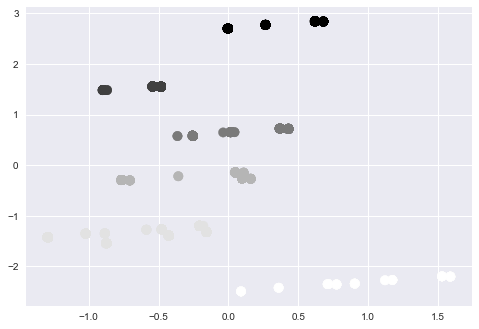

In [63]:
#plot using PCA method
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(2)

# Turn the dummified df with PCA
plot_columns = pca.fit_transform(df_dummy.ix[:,0:21])

# Plot based on the two dimensions, and shade by cluster label
plt.scatter(x=plot_columns[:,1], y=plot_columns[:,0], c=df_dummy["clusters"], s=90)
plt.show()

The resulting plot is reasonale clustered. However, because we are using PCA reduction into only 2 dimensions for plotting, we are aware that this plot does not represent the clsuter 100%. It is the best representation we can offer. As a result, we cluster the users into 6 different Clusters.

Now each user are in one of the six clusters. Our main recommendation system would be as follow:

1. Get the ID of the yelp user, say User 4.
3. Apply cluster method to that user and get User4's cluster number.
2. Find all users in the same cluster.
3. Get the restaurant ID for from that cluster and remove the one that User 4 had already reviewed.
4. From that list of restaurant we will pick the ones that are in the state that the user prefered.
5. Finally we will recommend the top 5 rated restaurants to User 4.

In addition, instead of recommend restaruant to User 4, we can also recommend other users to them. Since people in the same cluster share the same interest, we can recommend User 4 those people as connection. Again, the recommendation is based on location but not limit to that location. 

For a new user, yelp can cluster he or she into one the the 6 clusters based on past review information and create push the recommendation of either restaruants or similar users based on the location that user prefers. 


<a id = '3.3.4'></a>
### 3.3.4 Discussion about the K-modes method and other methods

We also attempted other clustering methods like K-Mean and Hierarchical Cluster. The method we tried is to turn the labels in each categorical into integer label and see it as a integer value. Though we are able to obtain some results from the two methods. The results would change drastically if we label different numbers for each category. Also the cluster centroid is impossible to interpret given our knowledge on these Clustering Methods. After reading on more papers, there is a way to use Hierarchical Cluster on categorical only dataset. It would be our interest in further investgation in the future.

There are always ways to expand and prefect the cluster and recommendation system. For future, I would try to twist the cluster methods like K-mean to make it fit categorical data. As of the recommendation system, creating a widget would be ideal for yelp to give recommendation. 

[Return to the Top](#intro)   |   [Return to Section Top](#3.3)

<a id = '4'></a>
# Summary and Discussion

Huge amount of data have been collected to establish profiles for everyone who uses internet and mobile network. Basing on these data, we can explore characteristics and rules underlying human behaviors. In this study, we took advantage of Yelp data to develop a recommender system. 

The core idea of our algorithms is to find similar people in the taste space for target users, because we deduce that people with similar taste may share similar preferences to restaurants. Three major methods are applied to search similar users. The most intuitive way is co-rating based similarity. For each target user, we searched the whole user list, and find out all the other users sharing co-rating restaurants. We calculated PCC between the target user and each co-rater and picked the users with top PCC as neighbors. This method is straight forward and accurate, while it also has shortcoming: going through the whole user list with calculating PCC is very time-consuming and people always need to face the situation of lacking co-raters. To overcome these problems, we developed algorithms based on reviews and restaurant features, separately. We clustered users into different groups and took the same group members as neighbors. In this way, we avoid the “co-rater problem”, since reviews and the features of different restaurants are generally effective and can be treated equally for each user.

To recommend restaurants for target users, we extracted high-rating restaurants from the list of closest neighbors, based on the rational that people with similar taste prefer the same restaurants. The similarity-based tactic can also be applied to predict restaurant rating for target users. We tested two methods of prediction on our samples.

The several methods we used to find neighbors are complementary to each other. The future direction will be combining them together to form a hybrid model to better address our questions.


[Return to the Top](#intro)